In [3]:
import sys
import os

py_file_location = "..."
sys.path.append(os.path.abspath(py_file_location))


In [4]:
from library import *
from model_DL import *
from functions import *
from metrics import *
from data_generator import *
from losses import *
from optimization import *
from parameters import *


/users/yacibena84/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/yacibena84/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/yacibena84/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/yacibena84/.local/lib/python3.6/site-packages/tensorflow/python/frame

In [5]:
# if dataset already created (load it)
### Train ### ==> ('dataset_BF_train')
dataset_train = np.load('Data/dataset/dataset_train_sigma_7_dim_10.npz') # dataset_train
dataset_train.files
dataset_train = dataset_train['arr_0']

### Test ### ==> np.load('dataset_BF_test_A')
dataset_test = np.load('Data/dataset/dataset_test_sigma_7_dim_10.npz')
dataset_test.files
dataset_test = dataset_test['arr_0']



#x_train, y_train = dataset_train[:,0:8], dataset_train[:,8:12]
x_train = dataset_train[:,0:8]


x_test, y_test = dataset_test[:,0:8], dataset_test[:,8:12]



In [6]:
n = 256
sampling = 1000
step_sampling = 100
x_min, x_max = p_min, p_max
y_min, y_max = p_min, p_max

Rxx, Ryy = np.meshgrid(np.linspace(x_min, x_max, n),
                     np.linspace(y_min, y_max, n))

R = np.c_[Rxx.ravel(), Ryy.ravel()]


U_1 = np.ones((R.shape[0],2)) * np.array([0.25, 0.5])*10
D_1 = np.ones((R.shape[0],2)) * np.array([0.5, 0.75])*10
U_2 = np.ones((R.shape[0],2)) * np.array([0.5, 0.25])*10
D_2 = np.ones((R.shape[0],2)) * np.array([0.75, 0.5])*10

d_11 = np.linalg.norm(U_1 - D_1, axis=1)
d_12 = np.linalg.norm(U_1 - D_2, axis=1)
d_1R = np.linalg.norm(U_1 - R  , axis=1)
d_21 = np.linalg.norm(U_2 - D_1, axis=1)
d_22 = np.linalg.norm(U_2 - D_2, axis=1)
d_2R = np.linalg.norm(U_2 - R  , axis=1)
d_R1 = np.linalg.norm(R   - D_1, axis=1)
d_R2 = np.linalg.norm(R   - D_2, axis=1)
D_test_R = np.c_[d_11, d_12, d_1R, d_21, d_22, d_2R, d_R1, d_R2].astype(np.float32)

def channel_gain_with_gaussian_fading(d, sigma=7, alpha=3):  # channel gain model
    s = np.random.normal(0.0, sigma, d.shape)
    h = s/np.sqrt(1+np.power(d, alpha))
    g = h**2
    return g

P_R_mean = np.zeros(Rxx.shape)
P_S_mean = np.zeros(Rxx.shape)
aplha_mean = np.zeros(Rxx.shape)

for i in range(int(sampling/step_sampling)):
    print(i)
    G = channel_gain_with_gaussian_fading((D_test_R[None,:,:]*np.ones((step_sampling,1,1))).reshape(-1,8), sigma)
    Y = model.predict(G, batch_size = 4096)
    del G
    alpha = Y[:,0]
    P_R = np.power(Y[:,1], 2)
    P_S = np.power(Y[:,2], 2)
    del Y
    P_R_mean = P_R_mean + np.sum(P_R.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    P_S_mean = P_S_mean + np.sum(P_S.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    aplha_mean = aplha_mean + np.sum(alpha.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
P_R_mean = P_R_mean/sampling
P_S_mean = P_S_mean/sampling
aplha_mean = aplha_mean/sampling




0


NameError: name 'model' is not defined

In [2]:
plt.figure(figsize=(10,1 0))
cax = plt.matshow(P_R_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max])
for v, l in ((U_1[0,:], "$U_1$"), (U_2[0,:], "$U_2$"), (D_1[0,:], "$D_1$"), (D_2[0,:], "$D_2$")):
        plt.scatter(v[0], v[1], marker="x", c='r')
        plt.annotate(l, (v[0]+0.2, v[1]), c='r')
plt.colorbar(cax, ticks=np.linspace(np.min(P_R_mean),np.max(P_R_mean),10))
plt.title('$P_R$')
plt.savefig('P_R.png', dpi=300)
plt.figure(figsize=(10,10))
cax = plt.matshow(P_S_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max])
plt.colorbar(cax, ticks=np.linspace(np.min(P_S_mean),np.max(P_S_mean),10))
for v, l in ((U_1[0,:], "$U_1$"), (U_2[0,:], "$U_2$"), (D_1[0,:], "$D_1$"), (D_2[0,:], "$D_2$")):
        plt.scatter(v[0], v[1], marker="x", c='r')
        plt.annotate(l, (v[0]+0.2, v[1]), c='r')
plt.title('$P_2$')
plt.savefig('P_2.png', dpi=300)
plt.figure(figsize=(10,10))
cax = plt.matshow(aplha_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max])
plt.colorbar(cax, ticks=np.linspace(np.min(aplha_mean),np.max(aplha_mean),10))
for v, l in ((U_1[0,:], "$U_1$"), (U_2[0,:], "$U_2$"), (D_1[0,:], "$D_1$"), (D_2[0,:], "$D_2$")):
        plt.scatter(v[0], v[1], marker="x", c='r')
        plt.annotate(l, (v[0]+0.2, v[1]), c='r')
plt.title(r'$\alpha$')
plt.savefig('alpha.png', dpi=300)

NameError: name 'plt' is not defined

In [4]:
# modified part


LD = {'10_-1':10**-1,'10_-0.75':10**-0.75,'10_-0.5':10**-0.5,'10_-0.25':10**-0.25,'10_0':10**0,'10_0.25':10**0.25,'10_0.5':10**0.5,'10_0.75':10**0.75,'10_1':10**1,'10_1.25':10**1.25,'10_1.5':10**1.5,'10_1.75':10**1.75,'10_2':10**2}

LR = {'10_-4':10**-4}


predicted_debit = []
predicted_debit_all = []
debit_gap, debit_gap_all = np.array([]), []

pdd_vmin, pdd_vmax, pdd_vmean, pdd_vstd = np.array([]), np.array([]), np.array([]), np.array([])
pdd_vmin_all, pdd_vmax_all, pdd_vmean_all, pdd_vstd_all = [], [], [], []

viloated_tau, viloated_tau_all = np.array([]), []

for ld_k in LD.keys():

  for lr_k in LR.keys():

      model = tf.keras.models.load_model('model_train_VF_S7_D10/Lambda = '+ld_k+'/weights/'+lr_k+'.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})

      ##### Evaluation on test set #####
      predictions = model.predict(x_test)
    
      # debit calculation for ground truth and predicted test set
      debit_hat_test = debit(x_test[:,0], x_test[:,1], x_test[:,2], x_test[:,3],x_test[:,4], x_test[:,5], x_test[:,6], x_test[:,7], predictions[:,0], predictions[:,1], predictions[:,2])
      debit_true_test = dataset(x_test[:,0], x_test[:,1], x_test[:,2], x_test[:,3],x_test[:,4], x_test[:,5], x_test[:,6], x_test[:,7], y_test[:,0], np.sqrt(y_test[:,1]), np.sqrt(y_test[:,2]), np.sqrt(y_test[:,3]))

      
      #predicted debit
  
      predicted_debit.append(debit_hat_test[:,8]) 
     
      ###### Gap Acheivable rate ######
      #Avreage debit gap between predicted and Brutefroce debit
      debit_gap = np.append(debit_gap, avreage_gap(debit_hat_test[:,8], debit_true_test[:,8])) #[:,7] : extracting debit from ND array

      ###### Primary degradation Violation ######
      #  Primary degradation percentage, mean and median calculation
      # qos_violation calculation
      tau_violation_count = Tau_Violation_Number(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2]) 

      viloated_tau = np.append(viloated_tau, Tau_Violation_percentage(x_test, tau_violation_count))

      # min, max, mean and std for primary debit degradation
      pdd_vmin, pdd_vmax, pdd_vmean, pdd_vstd =  np.append(pdd_vmin,pdd_min(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2])), np.append(pdd_vmax,pdd_max(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2])), np.append(pdd_vmean, pdd_mean(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2])), np.append(pdd_vstd,pdd_std(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2]))  
  # append data from the temporary list to the principal list
  debit_gap_all.append(debit_gap)

  predicted_debit_all.append(predicted_debit)

  viloated_tau_all.append(viloated_tau)
  pdd_vmin_all.append(pdd_vmin)
  pdd_vmax_all.append(pdd_vmax)
  pdd_vmean_all.append(pdd_vmean)
  pdd_vstd_all.append(pdd_vstd)

  # empty temporary lists
  predicted_debit = []
  debit_gap, viloated_tau = np.array([]), np.array([])

  pdd_vmin, pdd_vmax, pdd_vmean, pdd_vstd = np.array([]), np.array([]), np.array([]), np.array([])


In [5]:
LD = ['$10^{-1}$', '$10^{-0.75}$','$10^{-0.5}$', '$10^{-0.25}$','$10^{0}$', '$10^{0.25}$','$10^{0.5}$', '$10^{0.75}$','$10^{1}$','$10^{1.25}$','$10^{1.5}$','$10^{1.75}$','$10^{2}$']
LR = {'$10^{-4}$'}

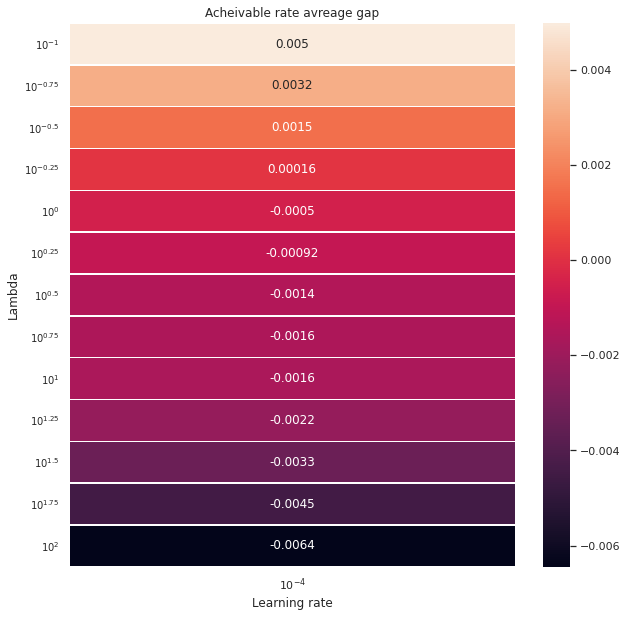

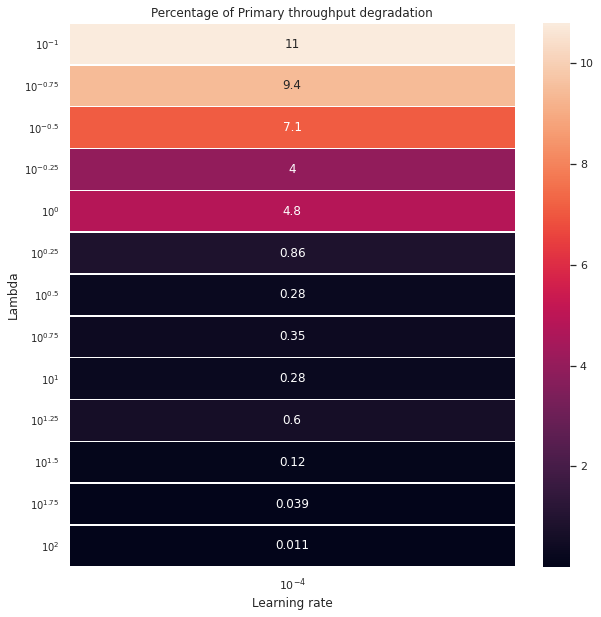

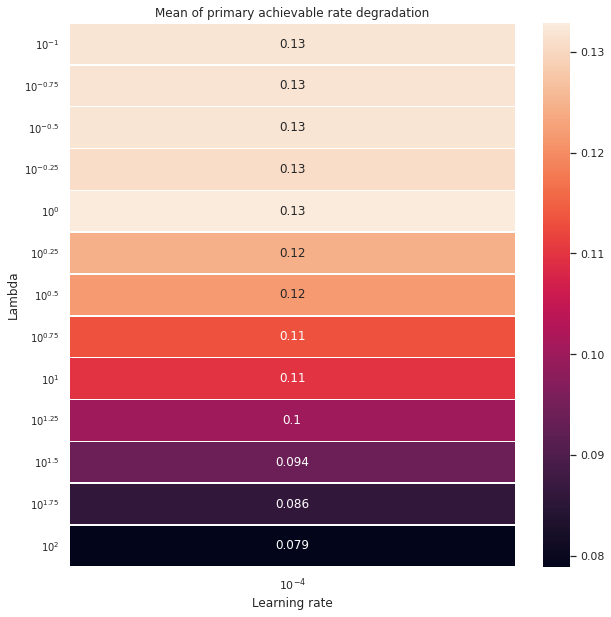

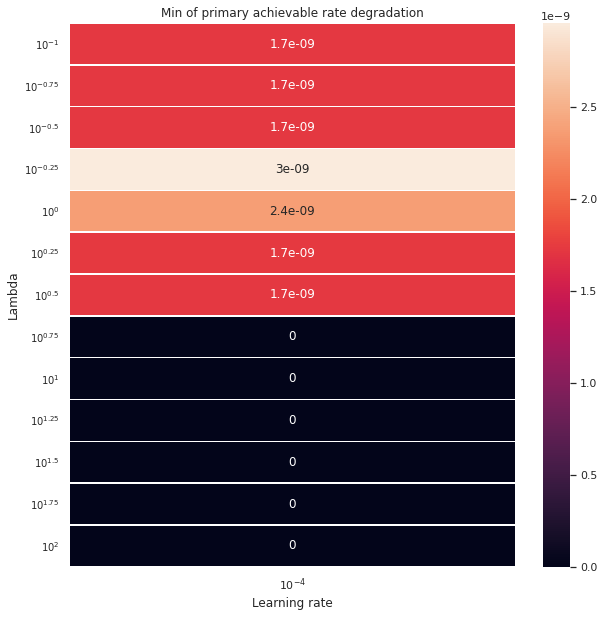

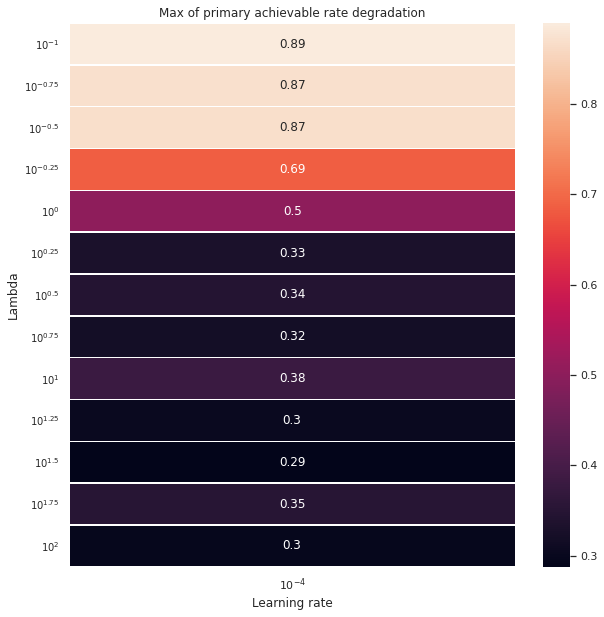

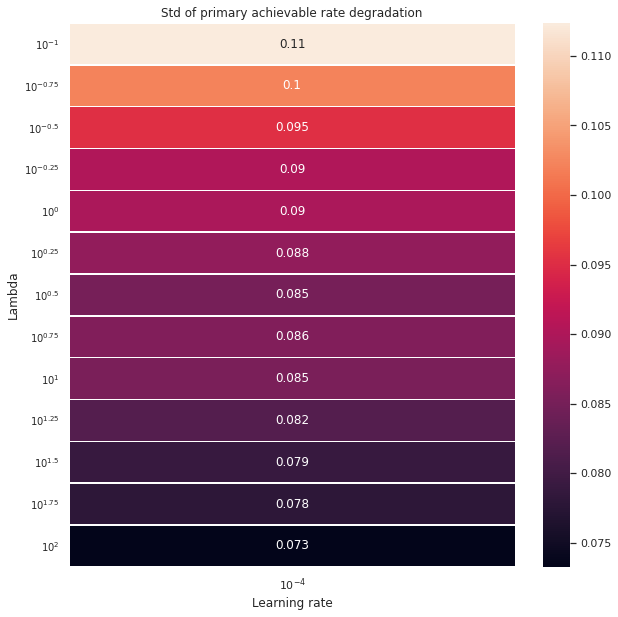

In [6]:
from matplotlib.colors import ListedColormap

def results_grid(title, data, lambda_label, lr_label):
  #df = pd.DataFrame(data, list(lambda_label.keys()), list(lr_label.keys()))
  df = pd.DataFrame(data, lambda_label, lr_label)

  fig, ax = plt.subplots(figsize=(10,10))
  plt.title(title)
  ax = sns.heatmap(df, annot=True, linewidths=.5, ax=ax)
  #ax = sns.boxplot(data=df, linewidth=2.5)
  plt.ylabel('Lambda')
  plt.xlabel('Learning rate')
  ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 10)
  plt.savefig(title, bbox_inches='tight')


################ Acheivable rate results ################

results_grid('Acheivable rate avreage gap',debit_gap_all, LD, LR)

################ QoS results ################
results_grid('Percentage of Primary throughput degradation',viloated_tau_all, LD, LR)

################ Primary achievable rate degradation results ################

results_grid('Mean of primary achievable rate degradation',pdd_vmean_all, LD, LR)
results_grid('Min of primary achievable rate degradation',pdd_vmin_all, LD, LR)
results_grid('Max of primary achievable rate degradation',pdd_vmax_all, LD, LR)
results_grid('Std of primary achievable rate degradation',pdd_vstd_all, LD, LR)




In [10]:
np.array(debit_gap_all).shape

(13, 1)

In [11]:
debit_true = dataset(x_test[:,0], x_test[:,1], x_test[:,2], x_test[:,3],x_test[:,4], x_test[:,5], x_test[:,6], x_test[:,7], y_test[:,0], np.sqrt(y_test[:,1]), np.sqrt(y_test[:,2]), np.sqrt(y_test[:,3]))

In [12]:
LD = {'10_-1':10**-1,'10_-0.75':10**-0.75,'10_-0.5':10**-0.5,'10_-0.25':10**-0.25,'10_0':10**0,'10_0.25':10**0.25,'10_0.5':10**0.5,'10_0.75':10**0.75,'10_1':10**1,'10_1.25':10**1.25,'10_1.5':10**1.5,'10_1.75':10**1.75,'10_2':10**2}

LR = {'10_-4':10**-4}


def CDB(x, y, debit_GT):
  sns.set(style='white')
  plt.rcParams["figure.figsize"] = (10,5)
  
  colors = ['plum', 'green', 'aqua', 'wheat', 'darkred', 'grey', 'peru', 'purple', 'black', 'red']
  m = ['P','o', 'v', '^', '<', '>', 'H', '8', 'p','s']
  marker_N = 20000

  fig = plt.figure(1)
  #sns.ecdfplot(data=x[0,0,:], label=r'Proposed method ($\lambda = 10^{-1}$)', lw=1, ls='dashed', marker='^',markerfacecolor='darkred', dash_capstyle='round',color = 'black', markersize=9, markevery=marker_N)

  sns.ecdfplot(data=x[6,0,:], label=r'Proposed method ($\lambda = 10^{0.5}$)', lw=1, ls='solid', marker='^',markerfacecolor='plum', dash_capstyle='round',color = 'black', markersize=9, markevery=marker_N)
  sns.ecdfplot(data=x[12,0,:], label=r'Proposed method ($\lambda = 10^{2}$)', lw=1, ls='solid', marker='o',markerfacecolor='wheat', dash_capstyle='round',color = 'black', markersize=9, markevery=marker_N)

  sns.ecdfplot(data=debit_GT[:,8], label='Bruteforce', lw=1, ls='solid', marker='s',markerfacecolor='red', dash_capstyle='round',color = 'black', markersize=9, markevery=marker_N)

  plt.grid()
  plt.xlabel("Achievable rate $(bit/s/Hz)$")
  
  #plt.title('Cumulative distribution function',fontweight="bold")
  lgd = plt.legend(loc=4,
          fancybox=True, shadow=True)

  fig.savefig('CDB_2.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
  fig.show()


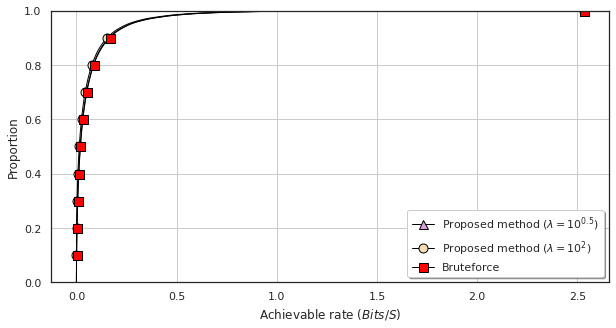

In [9]:
CDB(np.array(predicted_debit_all), list(LR.keys()),debit_true)

In [54]:
np.array(predicted_debit_all).shape

(13, 1, 200000)

In [13]:
def plot_learning_curve(title, data, val_data, ylab, x_lim, y_lim, Ld, Lr, filename):
  """
      Parameters:
         title : title of the figure (figure will be saved same as title)
         data: 1D array contains learning data history.
         ylab: y label.
         x_lim: set the x limits of the current axes.
         y_lim : set the y-limits of the current axes.
         filename : name of the file or path created to store figures.
      Returns:
         Plot for Achievable rate, Loss, Primary rate degradation and Qos violation evolution.
  """

  sns.set(style='white')
  plt.rcParams["figure.figsize"] = (10,5)

  colors = ['green', 'aqua', 'wheat', 'darkred', 'grey', 'peru', 'purple', 'black', 'plum']
  marker = ['-.',':','--','-']
  m = ['o', 'v', '^', '<', '>', 'H', '8', 'p','s','1','2','3','4','_','D','|','x','h','v']
  #markerfacecolor= ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted']

  #plt.title(title, fontweight="bold")
  # plum, wheat, red
  
  plt.plot(data[0][0][:], label=r'Training set ($\lambda = 10^{0.5}$)',ls='solid', lw=1, marker='^',markerfacecolor='plum',dash_capstyle='round',color = 'black', markersize=9, markevery=50)
  plt.plot(val_data[0][0][:], label='Validation set ($\lambda = 10^{0.5}$)',ls='dotted', lw=1,marker='^',markerfacecolor='plum',dash_capstyle='round',color = 'black', markersize=9, markevery=50)

  plt.plot(data[1][0][:], label=r'Training set ($\lambda = 10^{2}$)',ls='solid', lw=1,marker='o',markerfacecolor='wheat',dash_capstyle='round',color = 'black', markersize=9, markevery=50)
  plt.plot(val_data[1][0][:], label=r'Validation set ($\lambda = 10^{2}$)',ls='dotted', lw=1,marker='o',markerfacecolor='wheat',dash_capstyle='round',color = 'black', markersize=9, markevery=50)

  fig = plt.figure(1)
  plt.xlabel("Epochs")
  plt.grid()
  plt.ylabel(ylab)
  plt.xlim(x_lim)
  plt.ylim(y_lim)
  lgd = plt.legend(loc='best')#title="Learning rate"
  
  fig.savefig(title+'_vf''.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
  plt.show()
  plt.ion()
  plt.pause(1)
  plt.close()  



In [14]:
LD = {'10_0.5':10**0.5,'10_2':10**2}

LR = {'10_-4':10**-4}


Loss_temp, Loss_data = [], []

Throughput_temp, Throughput_data = [], []

V_Qos_temp, V_Qos_data = [], []

Rp_degradation_temp, Rp_degradation_data = [], []


for ld_k in LD.keys():
  for lr_k in LR.keys():
  
    history = np.load('/content/drive/MyDrive/Colab Notebooks/CodeVF/model_train_WN_VF_D10/Lambda = '+ld_k+'/history/'+lr_k+'.npy',allow_pickle='TRUE').item()
    
    Loss_temp.append(history['loss'])
    Throughput_temp.append(history['throughput'])# Achievable_Rate
    V_Qos_temp.append(history['Primary_ARDP'])# Primary_ARDP
    Rp_degradation_temp.append(history['Primary_Achievable_Rate_Degradation']) #
  
  Loss_data.append(Loss_temp)
  Throughput_data.append(Throughput_temp)
  V_Qos_data.append(V_Qos_temp)
  Rp_degradation_data.append(Rp_degradation_temp)

  Loss_temp, Throughput_temp, V_Qos_temp, Rp_degradation_temp  = [], [], [], []
   

In [15]:
LD = {'10_0.5':10**0.5,'10_2':10**2}

LR = {'10_-4':10**-4}


val_Loss_temp, val_Loss_data = [], []

val_Throughput_temp, val_Throughput_data = [], []

val_V_Qos_temp, val_V_Qos_data = [], []

val_Rp_degradation_temp, val_Rp_degradation_data = [], []


for ld_k in LD.keys():
  for lr_k in LR.keys():
  
    history = np.load('/content/drive/MyDrive/Colab Notebooks/CodeVF/model_train_WN_VF_D10/Lambda = '+ld_k+'/history/'+lr_k+'.npy',allow_pickle='TRUE').item()
    
    val_Loss_temp.append(history['val_loss'])
    val_Throughput_temp.append(history['val_throughput'])# Achievable_Rate
    val_V_Qos_temp.append(history['val_Primary_ARDP'])# Primary_ARDP
    val_Rp_degradation_temp.append(history['val_Primary_Achievable_Rate_Degradation']) #
  
  val_Loss_data.append(val_Loss_temp)
  val_Throughput_data.append(val_Throughput_temp)
  val_V_Qos_data.append(val_V_Qos_temp)
  val_Rp_degradation_data.append(val_Rp_degradation_temp)

  val_Loss_temp, val_Throughput_temp, val_V_Qos_temp, val_Rp_degradation_temp  = [], [], [], []
   

In [16]:
def percentage(x):
  x = np.array(x)*100
  x = x.tolist()
  return x
  
Rp_degradation_data = percentage(Rp_degradation_data)
V_Qos_data = percentage(V_Qos_data)

val_Rp_degradation_data = percentage(val_Rp_degradation_data)
val_V_Qos_data = percentage(val_V_Qos_data)

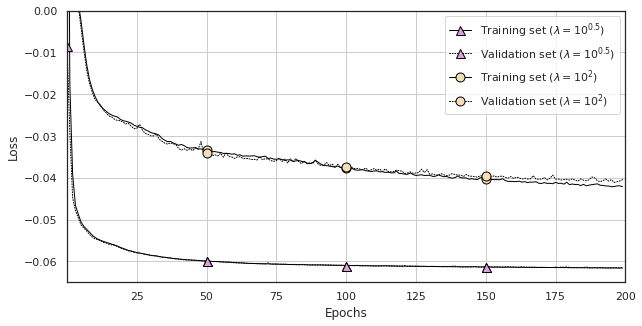

In [22]:
plot_learning_curve('Model loss', Loss_data, val_Loss_data, 'Loss', [0.1,200], [-0.065,0], LD, LR, '/Results_VF/Curve/')

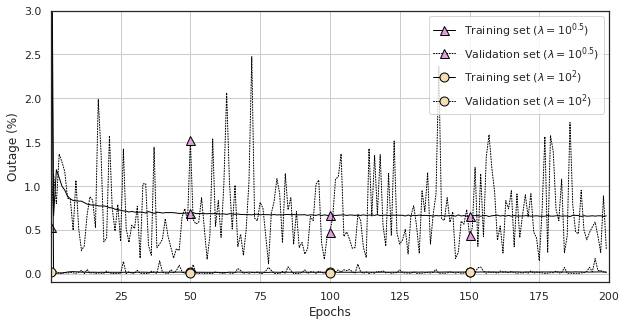

In [32]:
plot_learning_curve('Primary network violation', V_Qos_data, val_V_Qos_data, 'Outage (%)', [0.1,200], [-0.1,3], LD, LR, '/Results_VF/Curve/')

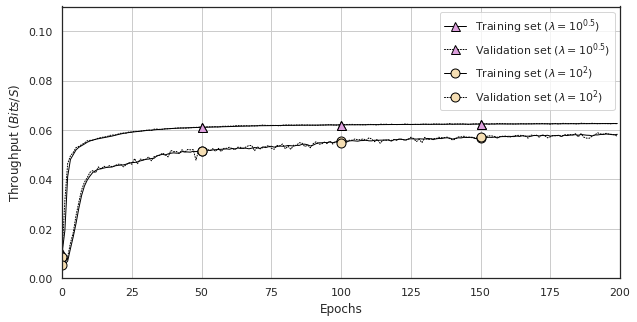

In [29]:
plot_learning_curve('Secondary achievable rate', Throughput_data,val_Throughput_data, r'Throughput $(bit/s/Hz)$', [0,200], [0,0.11], LD, LR,'/Results_VF/Curve/')

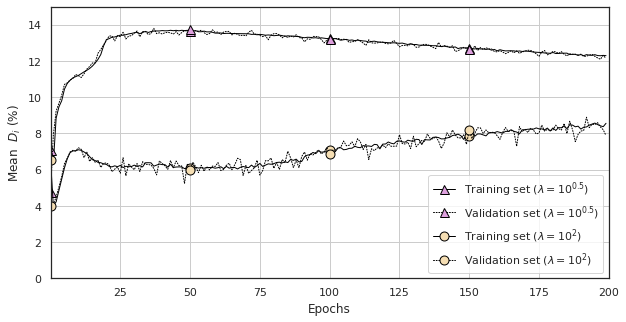

In [31]:
plot_learning_curve('Instantaneous primary acheivable rate degradation', Rp_degradation_data, val_Rp_degradation_data, 'Mean $\ D_{i}$ (%)', [0.1,200], [0,15], LD, LR, '/Results_VF/Curve/')

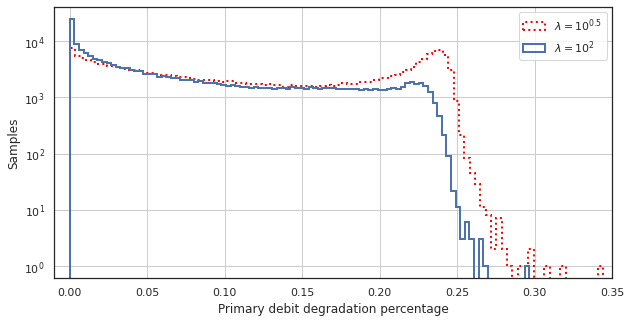

In [27]:
def Pdd_Hist(Grp, Gpp, Gsp, Alpha, Pr, Ps, Alpha2, Pr2, Ps2):
  """
    Parameters:
      Grp: Channel Gain between relay and primary receiver.
      Gpp: Channel Gain between primary transmitter and primary receiver. 
      Gsp: Channel Gain between secondary transmitter and primary receiver.
      Alpha: Array containing Alpha values.
      Pr: Array containing Power of relay.
      Ps: Array containing Power of secondary network.
    Returns:
      histogram for Primary debit degradation 
  """
  sns.set(style='white')
  plt.rcParams["figure.figsize"] = (10,5)
  
  res = pdd(Grp, Gpp, Gsp ,Alpha, Pr, Ps)
  res2 = pdd(Grp, Gpp, Gsp ,Alpha2, Pr2, Ps2)

  #fig, ax = plt.subplots(1) # Creates figure fig and add an axes, ax.
  
  plt.hist(res, 100, histtype='step', ls=':', lw = 2 , color='red',label='$\lambda = 10^{0.5}$')
  plt.hist(res2, 100, histtype='step', ls='-',  lw = 2, label='$\lambda = 10^{2}$')
  
  fig = plt.figure(1)
  plt.xlim((-0.01,0.35))
  plt.grid()
  plt.yscale('log')
  plt.xlabel('Primary debit degradation percentage')
  plt.ylabel('Samples')
  plt.legend(loc='best')
  #plt.annotate(r"$\lambda$ = "+'$'+Lambda_value.replace('_','^{')+'}$', xy=(0.05,0.9),xycoords='axes fraction',
  #           fontsize=14)


  fig.savefig('h_vf.png', bbox_inches='tight')
  plt.show()
  plt.ion()
  plt.pause(1)
  plt.close()  

LD = {'10_-1':10**-1,'10_-0.75':10**-0.75,'10_-0.5':10**-0.5,'10_-0.25':10**-0.25,'10_0':10**0,'10_0.25':10**0.25,'10_0.5':10**0.5,'10_0.75':10**0.75,'10_1':10**1,'10_1.25':10**1.25,'10_1.5':10**1.5,'10_1.75':10**1.75,'10_2':10**2}

LR = {'10_-4':10**-4}
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CodeVF/model_train_WN_VF_D10/Lambda = 10_0.5/weights/10_-4.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})
model2 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CodeVF/model_train_WN_VF_D10/Lambda = 10_2/weights/10_-4.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})

##### Evaluation on train set #####
predictions1 = model.predict(x_test)
predictions2 = model2.predict(x_test)

Pdd_Hist(x_test[:,0], x_test[:,1], x_test[:,6], predictions1[:,0], predictions1[:,1], predictions1[:,2], predictions2[:,0], predictions2[:,1], predictions2[:,2])
      

In [1]:
import tensorflow as tf
tf.version.VERSION


'2.5.0'